In this notebook we will provide a simple example of using FORCE learning (Sussillo and Abbott, 2009) to train an RNN to produce a sine wave. We will use principle components analysis to compute the dimensionality of the RNN activity. Further below, we will train the RNN to produce a fixed point and will test whether it is locally stable against perturbations in the RNN activity.

-J.M. Murray, May 2019

In [1]:
from pylab import *
%matplotlib inline

## Use FORCE learning to train an RNN to produce a sine wave

In [2]:
# First define parameters.

# Number of units:
n = 500

# Gain parameter, which adjusts the strength of recurrent weights:
g = 1.5

# Recurrent connectivity matrix:
j = g*np.random.randn(n,n)/n**0.5

# Time step (where the RNN time constant tau=1):
dt = 0.1

# Array of times:
tRange = np.arange(0, 500, dt)

# Desired output that I want to train the network to replicate:
f = np.sin(0.25*tRange)

# The vector feeding the output z(t) back into the network is fixed and random:
wFB = np.random.randn(n)

# Constant input to the network:
wIn = np.random.randn(n)
bIn = 0.0

# The activity matrix, which starts from a random configuration; x[t,j] is the 
# activity of neuron j at time step t:
x = np.zeros((len(tRange), n))
x[0] = np.random.randn(n)

# The inverse learning rate (Sussillo and Abbott suggest alpha ~ 1 to 100):
alpha = 1.

# The regularized inverse correlation matrix; p[t, :, :] is the nxn matrix at 
# time step t:
p = np.eye(n)/alpha

# The output, which I want to resemble f(t):
z = np.zeros(len(tRange))

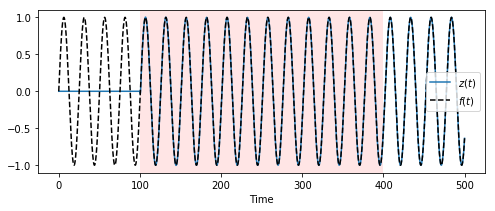

In [3]:
# Initialize the readout weights:
w = np.zeros(n)

# The main loop, which evolves everything in time (note t here is an integer, not actual time):
for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)
    rP = np.dot(p, np.tanh(x[t+1]))
    p = p - np.outer(rP, rP)/(1 + np.dot(np.tanh(x[t+1]), rP))
    err = f[t+1] - np.dot(w, np.tanh(x[t+1]))
    
    # Use FORCE learning to adjust the weights, turning it on after some time and turning it off
    # for testing at the end:
    if t > 0.2*len(tRange) and t < 0.8*len(tRange):
        dw = err*np.dot(p, np.tanh(x[t+1]))
        w = w + dw
    
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.axvspan(0.2*tRange[-1], 0.8*tRange[-1], facecolor=(1,0,0), alpha=0.1)
plt.plot(tRange, z)
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

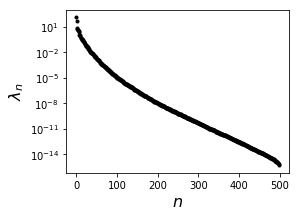

In [4]:
# Do principle components analysis by taking the eigendecomposition of the RNN activity correlation matrix during the testing phase:
r_test = np.tanh(x[int(0.8*tRange[-1]):])
r_mean = np.mean(r_test, axis=0)
r_meansub = r_test - r_mean
evals, evecs = eig(np.dot(r_meansub.T, r_meansub)/len(r_meansub))
evals, evecs = real(evals), real(evecs)  # evals may have a tiny imaginary part that we can ignore

# Sort the eigenvalues from largest to smallest, and sort the eigenvectors to match:
evecs_sorted = evecs[:,argsort(evals)[-1:0:-1]]
evals_sorted = sort(evals)[-1:0:-1]

# Plot the spectrum of eigenvalues from largest to smallest:
plt.figure(figsize=(4,3))
plt.semilogy(evals_sorted, '.k')
plt.xlabel('$n$', fontsize=16);
plt.ylabel('$\lambda_n$', fontsize=16);

In [5]:
# Compute the dimensionality from the PCA spectrum using the participation ratio.

d = np.sum(evals)**2/np.sum(evals**2)
print('PCA dimension:', d)

PCA dimension: 2.28686035304


**Exercise**: How does this compare with the dimensionality of activity in an RNN trained with BPTT?

**Exercise**: Try plotting the projections of the mean-subtracted RNN activity along the first two PC vectors (evecs_sorted[:,0] and evecs_sorted[:,1]).

## Use FORCE learning to learn a fixed point

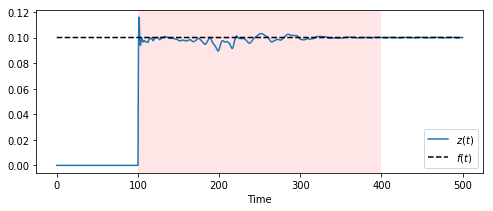

In [9]:
# New target function:
f = 0.1*np.ones_like(tRange)

# Initialize the readout weights and P matrix:
w = np.zeros(n)
p = np.eye(n)/alpha

# The main loop, which evolves everything in time (note t here is an integer, not actual time):
for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)
    rP = np.dot(p, np.tanh(x[t+1]))
    p = p - np.outer(rP, rP)/(1 + np.dot(np.tanh(x[t+1]), rP))
    err = f[t+1] - np.dot(w, np.tanh(x[t+1]))
    
    # Use FORCE learning to adjust the weights, turning it on after some time and turning it off
    # for testing at the end:
    if t > 0.2*len(tRange) and t < 0.8*len(tRange):
        dw = err*np.dot(p, np.tanh(x[t+1]))
        w = w + dw
    
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.axvspan(0.2*tRange[-1], 0.8*tRange[-1], facecolor=(1,0,0), alpha=0.1)
plt.plot(tRange, z)
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

In [10]:
x0 = x[0]

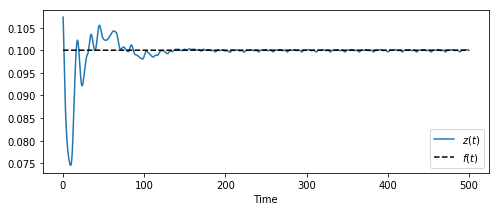

In [11]:
# Check that the fixed point is locally stable by perturbing the RNN state and running the RNN without learning.

x[0] = x[-1] + 0.1*np.random.randn(n)

for t in range(len(tRange)-1):
    x[t+1] = (1-dt)*x[t] + dt*(np.dot(j, np.tanh(x[t])) + bIn*wIn + z[t]*wFB)        
    z[t+1] = np.dot(w, tanh(x[t+1]))

# Plot the network output z, together with the desired output f; the shading shows where learning is turned on:
plt.figure(figsize=(8,3))
plt.plot(tRange[1:], z[1:])
plt.plot(tRange, f, '--k')
plt.xlabel('Time')
plt.legend(('$z(t)$', '$f(t)$'))

## Fixed points may be unstable if input vectors are degenerate

Mastrogiuseppe and Ostojic (2019) showed that, if the input and feedback vectors to the RNN are aligned and for target output values lying within a certain range and with weak recurrent connectivity, the RNN fails to learn the correct fixed point or the fixed point becomes unstable (see their Figs. 7 and 8). Here we'll show an example of this happening.

**Exercise**: Try changing the above simulation so that 
- g=0.3 (RNN connectivity strength)
- The input and feedback weights are equal to one another
- The RNN has a nonzero external input (e.g. bIn = 0.1)
- The target output has a constant value in the instability range given by Mastrogiuseppe and Ostojic (roughly -0.2 < f < -0.1)

Does the RNN learn the correct fixed point in this case? Is it stable to perturbations?